# **Import Required Libraries**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
from sklearn.metrics import roc_curve, roc_auc_score
import pickle
import joblib
import warnings
warnings.filterwarnings("ignore")

import rasterio
from rasterio.merge import merge
import glob
import os

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

# **Plot the ROC-AUC Curve**

In [8]:
# Load model and transformer
model_path = r"/content/drive/MyDrive/Bihar Project Work/ML_Models"

# Models
rf_model = joblib.load(open(os.path.join(model_path, "updated_Random_Forest.pkl"), 'rb'))
xgb_model = joblib.load(open(os.path.join(model_path, "updated_XGBoost.pkl"), 'rb'))
# adb_model = joblib.load(open(os.path.join(model_path, "Adaboost.pkl"), 'rb'))
# svm_model = joblib.load(open(os.path.join(model_path, "SVM.pkl"), 'rb'))
# et_model = joblib.load(open(os.path.join(model_path, "ExtraTrees.pkl"), 'rb'))
# st_model = joblib.load(open(os.path.join(model_path, "Stacked_Ensemble.pkl"), 'rb'))


In [9]:
# Import the testing data
testing_df = pd.read_csv("/content/drive/MyDrive/Bihar Project Work/Datasets/CSVs/updated_Testing_data.csv")
testing_df.head()

,Elevation,Slope,Aspect,Profile_Curve,NDVI,Plan_Curve,TWI,SPI,STI,Drainage_Density,...,Soil_8,Soil_10,Soil_11,Soil_13,Soil_14,Soil_15,Soil_16,Soil_17,Soil_18,Soil_19
0,-0.557309,-0.500820,-1.053026,-0.088560,-1.221238,-0.141896,1.240929,-0.019008,-0.036491,-0.424893,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.143247,-0.500820,-1.053026,-0.088560,-0.179780,-0.141896,1.311489,-0.019008,-0.036592,0.129120,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.892284,1.048205,-0.535059,1.014249,1.077137,-2.797155,-0.320880,-0.018786,-0.036592,-0.727940,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.370313,-0.500820,-1.053026,-0.088560,-0.374805,-0.141896,1.336109,-0.019008,-0.036558,0.221017,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.316886,-0.220329,1.843669,-0.876281,1.588511,-0.141896,-0.707699,-0.019008,-0.036592,0.961151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Select the best feature
X_test = testing_df[rf_model.feature_names_in_]
y_test = pd.read_csv('/content/drive/MyDrive/Bihar Project Work/Datasets/CSVs/updated_y_test_data.csv')

In [11]:
# Define the stacking classifier
classifiers =[
        # ('adb', adb_model),
        # ('et', et_model),
        ('rf', rf_model),
        # ('svm', svm_model),
        ('xgb', xgb_model),
        # ('stack', st_model)
    ]

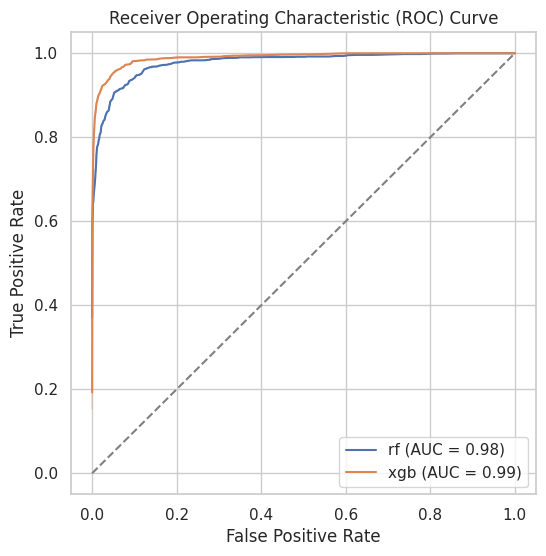

In [12]:
# Create a plot for ROC curves
plt.figure(figsize=(6, 6), dpi=100)

sns.set(style="whitegrid")
# sns.set(font='Times New Roman')

# Loop through each classifier
for name, classifier in classifiers:
    # Predict the test data
    classifier.predict(X_test)

    # Predict probabilities
    y_pred_prob = classifier.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Calculate the AUC score
    auc = roc_auc_score(y_test, y_pred_prob)

    # Plot the ROC curve
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {auc:.2f})")

# Add labels and legend
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
legend = plt.legend(loc='best')

plt.savefig('/content/drive/MyDrive/Bihar Project Work/Outputs/Updated_Roc_Auc_Curve_RF_XGB.jpg', dpi=900)
# Show the plot
plt.show()

# **Plot the Validation Metrics**

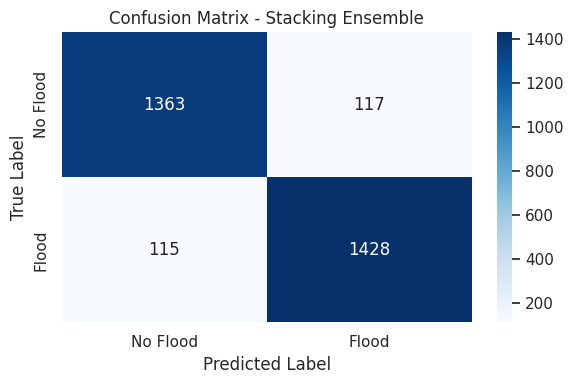

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict using your pretrained model
y_pred = rf_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: Define class names
labels = ['No Flood', 'Flood']  # Update based on your use case

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Stacking Ensemble')
plt.tight_layout()
plt.show()


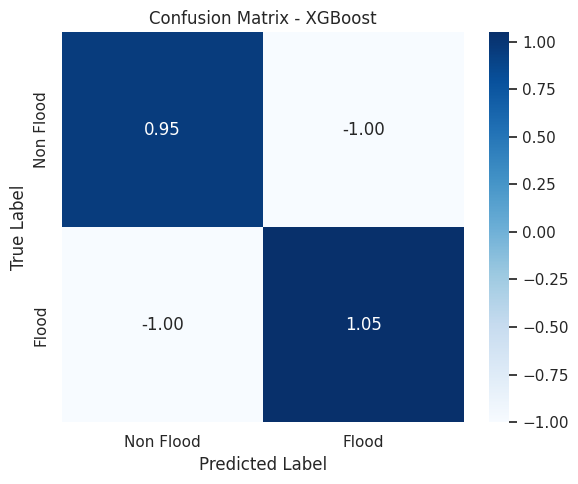

In [16]:
# Get predictions
y_pred = rf_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Standardize: convert to z-scores
mean = np.mean(cm)
std = np.std(cm)
cm_standardized = (cm - mean) / std

# Class labels
labels = ['Non Flood', 'Flood']

# Plot with seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm_standardized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost')
plt.savefig('/content/drive/MyDrive/Bihar Project Work/Outputs/Updated_Confusion_Matrix_RF.jpg', dpi=900)
plt.tight_layout()
plt.show();

<Figure size 640x480 with 0 Axes>